# Coursera Final Capstone Project: Battle of the Neighborhoods

### Project Description / Requirements:

This capstone project will be graded by your peers. This capstone project is worth 70% of your total grade. The project will be completed over the course of 2 weeks. Week 1 submissions will be worth 30% whereas week 2 submissions will be worth 40% of your total grade.

**For this week, you will required to submit the following:**

    A description of the problem and a discussion of the background. (15 marks)
    A description of the data and how it will be used to solve the problem. (15 marks)

**For the second week, the final deliverables of the project will be:**

    A link to your Notebook on your Github repository, showing your code. (15 marks)
    A full report consisting of all of the following components (15 marks):

    Introduction where you discuss the business problem and who would be interested in this project.
    Data where you describe the data that will be used to solve the problem and the source of the data.
    Methodology section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.
    Results section where you discuss the results.
    Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.
    Conclusion section where you conclude the report.

    Your choice of a presentation or blogpost. (10 marks)

### Background

**500,000 people moved from California to Arizona from 2010 to 2018, for a variety of reasons, but arguably due to California's high cost of living.**

Hypothetical scenario: data scientist, John Doe, currently lives in California, but he finds a remote data science jobs that would allow him to relocate, and California is too expensive.  He hears good things about the neighboring state, Arizona, **specifically the Phoenix, AZ metropolitan area.**

But John Doe really likes the feel of his current neighbhorhood / current town, in terms of venues nearby: parks, stores, restaurants, etc.  **What community in teh greater Pheonix area would be John's best fit to his current CA city?**

### Goal

Create a notebook that does the following:
1. Allow an input city for comparision (where John Doe currently lives)
2. Load a csv file that compiles suburbs in the Phoenix, AZ metropolitan area (created manually from wiki page: https://en.wikipedia.org/wiki/Phoenix_metropolitan_area)
3. Use FourSquare data to gather venue statistics about both the current input city and ALL community cities in the greater Phoenix area.
4. Use clustering models to determine which city near Phoenix is most similar to John's current city, as a "best-fit" location to move to.

### Data

Most of the data will come from Foursquare API, which includes venue information given a latitude and longitude location: for example, restaurants, museums, parks, entertainment venues, etc., within a fixed distance from a given location.

The only other data used will be a csv file created manually, which just lists out all the communities (with population > 10,000) in the Phoenix, AZ metropolitan area.  List originated from: https://en.wikipedia.org/wiki/Phoenix_metropolitan_area

This csv was constructed manually and saved to github at: https://raw.githubusercontent.com/KyleStewartPhD/IBMcapstone/master/phoenix%20suburbs.csv 

In [86]:
import pandas as pd

cities_url = 'https://raw.githubusercontent.com/KyleStewartPhD/IBMcapstone/master/phoenix%20suburbs.csv'
cities = pd.read_csv(az_cities_url, thousands=',')  #read csv, while turning numbers strings with commas into regular int format
cities['State'] = 'AZ' #add state information, which is all AZ so far
cities

,City,Population,State
0,Phoenix,1626078,AZ
1,Mesa,496401,AZ
2,Chandler,253458,AZ
3,Scottsdale,249950,AZ
4,Glendale,246709,AZ
5,Gilbert,242354,AZ
6,Tempe,185038,AZ
7,Peoria,168181,AZ
8,Surprise,134085,AZ
9,Avondale,84025,AZ


In [87]:
#These are manual inputs for the starting comparision city.  The city "John Doe" currently lives in, in the description
my_city = "Rancho Cucamonga"
my_state = "CA"
my_pop = 177751

#add this city to our dataframe as the first row
cities.loc[-1] = [my_city, my_pop, my_state]  # add a row with input city
cities.index = cities.index + 1  # shifting index
cities = cities.sort_index()  # sorting by index

cities

,City,Population,State
0,Rancho Cucamonga,177751,CA
1,Phoenix,1626078,AZ
2,Mesa,496401,AZ
3,Chandler,253458,AZ
4,Scottsdale,249950,AZ
5,Glendale,246709,AZ
6,Gilbert,242354,AZ
7,Tempe,185038,AZ
8,Peoria,168181,AZ
9,Surprise,134085,AZ


#### Import all the libraries we're going to use

In [57]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you need to install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you need to install folium
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                       

In [88]:
#Note: geolocator is finnicky sometimes.  Might have to run this cell a couple times before it works correctly for all cities.
lats = []
longs = []
for i in range(0,cities.shape[0]):
    #print(cities['City'].iloc[i])
    address = cities['City'].iloc[i]+', '+ cities['State'].iloc[i] #get city, state address string
    geolocator = Nominatim(user_agent="phoenix_az_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of '+ address + ' is {}, {}.'.format(latitude, longitude))
    lats.append(latitude)
    longs.append(longitude)

The geograpical coordinate of Rancho Cucamonga, CA is 34.1033192, -117.5751735.
The geograpical coordinate of Phoenix, AZ is 33.4484367, -112.0741417.
The geograpical coordinate of Mesa, AZ is 33.4151117, -111.8314773.
The geograpical coordinate of Chandler, AZ is 33.3062223, -111.8413317.
The geograpical coordinate of Scottsdale, AZ is 33.4942189, -111.9260184.
The geograpical coordinate of Glendale, AZ is 33.5386858, -112.1859941.
The geograpical coordinate of Gilbert, AZ is 33.3527632, -111.7890373.
The geograpical coordinate of Tempe, AZ is 33.4255056, -111.9400125.
The geograpical coordinate of Peoria, AZ is 33.5806115, -112.2372942.
The geograpical coordinate of Surprise, AZ is 39.8158066, 46.7520879.
The geograpical coordinate of Avondale, AZ is 33.4354989, -112.3495572.
The geograpical coordinate of Goodyear, AZ is 33.4353672, -112.3576005.
The geograpical coordinate of Buckeye, AZ is 33.3702748, -112.5838673.
The geograpical coordinate of Casa Grande, AZ is 32.8795022, -111.75

In [89]:
#add new lat and long info to dataframe
cities['Latitude'] = lats
cities['Longitude'] = longs
cities

,City,Population,State,Latitude,Longitude
0,Rancho Cucamonga,177751,CA,34.103319,-117.575174
1,Phoenix,1626078,AZ,33.448437,-112.074142
2,Mesa,496401,AZ,33.415112,-111.831477
3,Chandler,253458,AZ,33.306222,-111.841332
4,Scottsdale,249950,AZ,33.494219,-111.926018
5,Glendale,246709,AZ,33.538686,-112.185994
6,Gilbert,242354,AZ,33.352763,-111.789037
7,Tempe,185038,AZ,33.425506,-111.940012
8,Peoria,168181,AZ,33.580612,-112.237294
9,Surprise,134085,AZ,39.815807,46.752088


In [94]:
#for some reason, geocorder gave wrong long/lat for a few cities:

#Maricopa, AZ.  Real value: 33.0581° N, 112.0476° W 
cities.loc[ cities['City']=='Maricopa', ['Latitude']] = 33.0581
cities.loc[ cities['City']=='Maricopa', ['Longitude']] = -112.0476

#Surprise, AZ.  Real value: 33.6292° N, 112.3679° W
cities.loc[ cities['City']=='Surprise', ['Latitude']] = 33.6292
cities.loc[ cities['City']=='Surprise', ['Longitude']] = -112.3679

cities

#test_loc = geolocator.geocode('Maricopa, AZ')
#print(test_loc.latitude, test_loc.longitude)

,City,Population,State,Latitude,Longitude
0,Rancho Cucamonga,177751,CA,34.103319,-117.575174
1,Phoenix,1626078,AZ,33.448437,-112.074142
2,Mesa,496401,AZ,33.415112,-111.831477
3,Chandler,253458,AZ,33.306222,-111.841332
4,Scottsdale,249950,AZ,33.494219,-111.926018
5,Glendale,246709,AZ,33.538686,-112.185994
6,Gilbert,242354,AZ,33.352763,-111.789037
7,Tempe,185038,AZ,33.425506,-111.940012
8,Peoria,168181,AZ,33.580612,-112.237294
9,Surprise,134085,AZ,33.629200,-112.367900


In [97]:
phoenix_lat = cities['Latitude'].iloc[1]
phoenix_long = cities['Longitude'].iloc[1]

# create map of New York using latitude and longitude values
phoenix_map = folium.Map(location=[phoenix_lat, phoenix_long], zoom_start=9)

# add markers to map
for lat, lng, city in zip(cities['Latitude'], cities['Longitude'], cities['City']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(phoenix_map)  
    
phoenix_map

### OK, so we have the lat/long data of all pertinent cities, and we have a nice map of the cities around Phoenix.  

### Now let's gather Foursquare venue data for all cities.  These will be the inputs to our clustering model

In [98]:
#Foursquare credentials
CLIENT_ID = 'SJYY0EQQ5BWSVO21FST51XCBSUHIM3DQQJDQTUT01CUVESAZ' # your Foursquare ID
CLIENT_SECRET = 'KGGU0NVWSLI5CEGLLMED4RW4VSHVDEZLNRGST0AUH1IBJLVY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SJYY0EQQ5BWSVO21FST51XCBSUHIM3DQQJDQTUT01CUVESAZ
CLIENT_SECRET:KGGU0NVWSLI5CEGLLMED4RW4VSHVDEZLNRGST0AUH1IBJLVY


Let's start by looking at venues around our input town:

In [115]:
city_name = 'Rancho Cucamonga'

city_data = cities[cities['City']==city_name]

city_latitude = cities['Latitude'].values[0] # neighborhood latitude value
city_longitude = cities['Longitude'].values[0] # neighborhood longitude value

print('Latitude and longitude values of {} are {}, {}.'.format(city_name, 
                                                               city_latitude, 
                                                               city_longitude))

# get Foursquare venues 
radius = 1000 #1 km from city center
LIMIT = 200 #limit to 200 results
latitude = city_latitude
longitude = city_longitude
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)

results = requests.get(url).json()
#results    #uncomment to print out ALL the results



Latitude and longitude values of Rancho Cucamonga are 34.1033192, -117.5751735.


In [100]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [118]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,K-Towne88,Korean Restaurant,34.106049,-117.576762
1,Haven City Market,Food Court,34.100049,-117.574065
2,Panera Bread,Bakery,34.107140,-117.575372
3,Sushi Martini,Japanese Restaurant,34.105499,-117.570918
4,The Coffee Bean & Tea Leaf,Coffee Shop,34.105686,-117.576451


Define a function to search for venue types for ALL neighbhorhoods, just like we did above.

In [119]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [120]:
# run the function for all neighbhorhoods
city_venues = getNearbyVenues(names=cities['City'],
                                   latitudes=cities['Latitude'],
                                   longitudes=cities['Longitude']
                                  )

Rancho Cucamonga
Phoenix
Mesa
Chandler
Scottsdale
Glendale
Gilbert
Tempe
Peoria
Surprise
Avondale
Goodyear
Buckeye
Casa Grande
Maricopa
Apache Junction
Queen Creek
El Mirage
Florence
Fountain Hills
Eloy
Paradise Valley
Coolidge


In [121]:
print("venues shape is:", city_venues.shape)

#print("each neighbhorhood had how many venues?: \n", toronto_venues.groupby('Neighborhood').count() )

print('There are {} uniques categories.'.format(len(city_venues['Venue Category'].unique())))
city_venues.head()

venues shape is: (858, 7)
There are 200 uniques categories.


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rancho Cucamonga,34.103319,-117.575174,K-Towne88,34.106049,-117.576762,Korean Restaurant
1,Rancho Cucamonga,34.103319,-117.575174,Haven City Market,34.100049,-117.574065,Food Court
2,Rancho Cucamonga,34.103319,-117.575174,Panera Bread,34.107140,-117.575372,Bakery
3,Rancho Cucamonga,34.103319,-117.575174,Sushi Martini,34.105499,-117.570918,Japanese Restaurant
4,Rancho Cucamonga,34.103319,-117.575174,The Coffee Bean & Tea Leaf,34.105686,-117.576451,Coffee Shop


**OK now let's clean up the data a bit so we can run clustering. Start by one-hot encoding venue categories¶**


In [123]:
# one hot encoding
city_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
city_onehot['City'] = city_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
city_onehot = city_onehot[fixed_columns]

city_onehot.head()


,City,ATM,Accessories Store,Advertising Agency,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Australian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Carpet Store,Chinese Restaurant,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Stadium,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,English Restaurant,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Flower Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gun Shop,Gym,Gym / Fitness Center,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Home Service,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Opera House,Optical Shop,Paper / Office Supplies Store,Park,Pawn Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Post Office,Pub,Public Art,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supplement Shop,Sushi Restaurant,Taco Place,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tour Provider,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Rancho Cucamonga,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Rancho Cucamonga,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Rancho Cucamonga,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [188]:
print("venues shape is : ", city_onehot.shape)

city_grouped = city_onehot.groupby('City').mean().reset_index()
print("grouped venues shape is : ", city_grouped.shape)

#add population as data to keep (for city similarity)
city_grouped = city_grouped.sort_values(by='City')
cities_sorted = cities.sort_values(by='City').reset_index(drop=True)
#city_grouped['Population'] = cities_sorted['Population']
city_grouped


venues shape is :  (858, 201)
grouped venues shape is :  (23, 201)


,City,ATM,Accessories Store,Advertising Agency,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Australian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Carpet Store,Chinese Restaurant,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Stadium,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,English Restaurant,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Flower Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gun Shop,Gym,Gym / Fitness Center,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Home Service,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Opera House,Optical Shop,Paper / Office Supplies Store,Park,Pawn Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Post Office,Pub,Public Art,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supplement Shop,Sushi Restaurant,Taco Place,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tour Provider,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Apache Junction,0.000000,0.0000,0.00,0.000000,0.058824,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.029412,0.029412,0.000,0.000,0.00,0.00,0.00000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00000,0.029412,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.029412,0.0,0.000000,0.00,0.029412,0.00,0.00,0.00,0.000000,0.000000,0.058824,0.000000,0.000000,0.029412,0.000000,0.029412,0.029412,0.000000,0.0000,0.000000,0.00000,0.00,0.0000,0.00,0.029412,0.117647,0.0000,0.000000,0.0000,0.0000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.029412,0.000000,0.000000,0.000000,0.0000,0.00,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0000,0.0000,0.000000,0.00,0.000000,0.0000,0.00,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.029412,0.00,0.0000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000,0.000000,0.000000,0.00,0.000000,0.00,0.029412,0.088235,0.058824,0.000000,0.000000,0.000000,0.000000,0.00,0.

**Lets put them in decending order of most common venues, and create a pandas df*

In [125]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [205]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = city_grouped['City']
#city_venues_sorted['Population'] = city_grouped['City']

for ind in np.arange(city_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Apache Junction,Fast Food Restaurant,Pharmacy,Pizza Place,Convenience Store,American Restaurant,Sandwich Place,Gas Station,Mexican Restaurant,Coffee Shop,Farmers Market
1,Avondale,Mexican Restaurant,Automotive Shop,Park,Social Club,Burger Joint,Discount Store,Seafood Restaurant,Fast Food Restaurant,Diner,Fish & Chips Shop
2,Buckeye,Discount Store,Mexican Restaurant,Coffee Shop,Gas Station,Pizza Place,Convenience Store,Sandwich Place,Park,Café,Bank
3,Casa Grande,Mexican Restaurant,City Hall,Café,New American Restaurant,Football Stadium,Chinese Restaurant,Ice Cream Shop,American Restaurant,Pizza Place,Burger Joint
4,Chandler,Mexican Restaurant,Taco Place,Italian Restaurant,Park,Bar,Brewery,Bridal Shop,Beer Bar,Café,Lounge


#### all right, this dataset is looking good. Let's actually cluster the neighborhoods!

#### We want to try the k-means clustering with different k values to find the "elbow" where the optimal k-value is

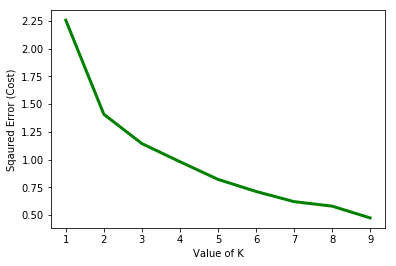

In [257]:
#let's try different k-means clustering fits, with different k's, to find optimum k value
import matplotlib.pyplot as plt  
from matplotlib import style 
%matplotlib inline

city_grouped_clustering = city_grouped
#city_grouped_clustering['Population'] = cities_sorted['Population']/cities_sorted['Population'].max()  #uncomment if you want to include population in analysis
city_grouped_clustering = city_grouped_clustering.drop('City', 1)

cost =[] 
kmax=10
for i in range(1, kmax): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(city_grouped_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, kmax), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 
  
# the point of the elbow is the  
# most optimal value for choosing k 
kclusters = 7  #there isn't exactly an elbow, but k=7 looks good enough

In [258]:
#set number of clusters
#kclusters = 10

#city_grouped_clustering = city_grouped
#city_grouped_clustering['Population'] = cities_sorted['Population']/cities_sorted['Population'].max()  #uncomment if you want to include population in analysis
#city_grouped_clustering = city_grouped_clustering.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

#city_grouped_clustering.head()

array([6, 2, 2, 0, 0, 3, 2, 2, 2, 0], dtype=int32)

In [259]:
# add clustering labels
try: 
    city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_) 
except: 
    #if you've run the above line before alreayd you can't instert it again.  Just re-define it
    city_venues_sorted['Cluster Labels'] = kmeans.labels_

city_merged = cities

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
city_merged = city_merged.join(city_venues_sorted.set_index('City'), on='City')

city_merged



,City,Population,State,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Rancho Cucamonga,177751,CA,34.103319,-117.575174,0,Mexican Restaurant,Bakery,American Restaurant,Coffee Shop,Japanese Restaurant,Clothing Store,Burger Joint,Fast Food Restaurant,Bank,Discount Store
1,Phoenix,1626078,AZ,33.448437,-112.074142,1,Coffee Shop,Hotel,Lounge,Pizza Place,American Restaurant,Music Venue,Basketball Stadium,Salon / Barbershop,Bar,Cocktail Bar
2,Mesa,496401,AZ,33.415112,-111.831477,0,Mexican Restaurant,Brewery,Sandwich Place,Bank,Fast Food Restaurant,Hotel,Bookstore,Martial Arts Dojo,Hot Dog Joint,Ice Cream Shop
3,Chandler,253458,AZ,33.306222,-111.841332,0,Mexican Restaurant,Taco Place,Italian Restaurant,Park,Bar,Brewery,Bridal Shop,Beer Bar,Café,Lounge
4,Scottsdale,249950,AZ,33.494219,-111.926018,0,Coffee Shop,American Restaurant,New American Restaurant,Bar,Pizza Place,Taco Place,Mexican Restaurant,Hotel,Italian Restaurant,Cocktail Bar
5,Glendale,246709,AZ,33.538686,-112.185994,0,Mexican Restaurant,Boutique,American Restaurant,Coffee Shop,Bar,Gift Shop,Park,Sandwich Place,Burger Joint,Eastern European Restaurant
6,Gilbert,242354,AZ,33.352763,-111.789037,0,Mexican Restaurant,Ice Cream Shop,Sandwich Place,Italian Restaurant,Coffee Shop,Plaza,Fast Food Restaurant,Farmers Market,Breakfast Spot,Brewery
7,Tempe,185038,AZ,33.425506,-111.940012,0,Coffee Shop,Pizza Place,Mexican Restaurant,Sandwich Place,American Restaurant,Breakfast Spot,Bar,Chinese Restaurant,Burger Joint,Mediterranean Restaurant
8,Peoria,168181,AZ,33.580612,-112.237294,0,Fast Food Restaurant,Theater,Pharmacy,Thrift / Vintage Store,Big Box Store,Donut Shop,Bar,Automotive Shop,Mexican Restaurant,Intersection
9,Surprise,134085,AZ,33.629200,-112.367900,0,Baseball Stadium,Baseball Field,Park,Hotel,Tennis Court,Sushi Restaurant,Fast Food Restaurant,Lake,Dog Run,Pizza Place


So how did the clustering divide up the neighbhorhoods? Let's look at each cluster to see common themes

In [260]:

for i in range(0, kclusters):
    print("\nfor Cluster ", i)
    print("1st: ", city_merged[city_merged['Cluster Labels'] == i]['1st Most Common Venue'].values )    
    print("2nd: ", city_merged[city_merged['Cluster Labels'] == i]['2nd Most Common Venue'].values )


for Cluster  0
1st:  ['Mexican Restaurant' 'Mexican Restaurant' 'Mexican Restaurant'
 'Coffee Shop' 'Mexican Restaurant' 'Mexican Restaurant' 'Coffee Shop'
 'Fast Food Restaurant' 'Baseball Stadium' 'Mexican Restaurant'
 'Mexican Restaurant' 'Pharmacy']
2nd:  ['Bakery' 'Brewery' 'Taco Place' 'American Restaurant' 'Boutique'
 'Ice Cream Shop' 'Pizza Place' 'Theater' 'Baseball Field' 'City Hall'
 'Pizza Place' 'Pizza Place']

for Cluster  1
1st:  ['Coffee Shop']
2nd:  ['Hotel']

for Cluster  2
1st:  ['Mexican Restaurant' 'Discount Store' 'Mexican Restaurant'
 'Mexican Restaurant' 'Convenience Store']
2nd:  ['Automotive Shop' 'Mexican Restaurant' 'Discount Store' 'Sandwich Place'
 'Mexican Restaurant']

for Cluster  3
1st:  ['Pizza Place']
2nd:  ['Mexican Restaurant']

for Cluster  4
1st:  ['Football Stadium']
2nd:  ['Pawn Shop']

for Cluster  5
1st:  ['Fish & Chips Shop']
2nd:  ['Home Service']

for Cluster  6
1st:  ['American Restaurant' 'Fast Food Restaurant']
2nd:  ['Discount Store' 

Let's map out the clusters and see where they fall in the city

In [261]:
target_city = cities['City'].iloc[0]
#print(target_city)
target_cluster = city_merged['Cluster Labels'][city_merged['City']==target_city].values[0]
#print(target_cluster)
print("Keep in mind, the cluster number for target town: " + target_city + " is Cluster #" + str(target_cluster))

Keep in mind, the cluster number for target town: Rancho Cucamonga is Cluster #0


In [262]:
phoenix_lat = cities['Latitude'].iloc[1]
phoenix_long = cities['Longitude'].iloc[1]

# create map
map_clusters = folium.Map(location=[phoenix_lat, phoenix_long], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged['Latitude'], city_merged['Longitude'], city_merged['City'], city_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

So there are a number of communities similar to our target.  Which one is closest in population size?

In [263]:
city_merged[city_merged['Cluster Labels']==target_cluster].sort_values(by='Population')

,City,Population,State,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Fountain Hills,24583,AZ,33.611711,-111.717361,0,Pharmacy,Pizza Place,Grocery Store,American Restaurant,Bank,Mexican Restaurant,Hardware Store,Shipping Store,Sports Bar,Spanish Restaurant
16,Queen Creek,39184,AZ,33.248386,-111.634158,0,Mexican Restaurant,Pizza Place,Fast Food Restaurant,American Restaurant,Sandwich Place,Fried Chicken Joint,Convenience Store,Coffee Shop,Cosmetics Shop,Pharmacy
13,Casa Grande,55477,AZ,32.879502,-111.757352,0,Mexican Restaurant,City Hall,Café,New American Restaurant,Football Stadium,Chinese Restaurant,Ice Cream Shop,American Restaurant,Pizza Place,Burger Joint
9,Surprise,134085,AZ,33.629200,-112.367900,0,Baseball Stadium,Baseball Field,Park,Hotel,Tennis Court,Sushi Restaurant,Fast Food Restaurant,Lake,Dog Run,Pizza Place
8,Peoria,168181,AZ,33.580612,-112.237294,0,Fast Food Restaurant,Theater,Pharmacy,Thrift / Vintage Store,Big Box Store,Donut Shop,Bar,Automotive Shop,Mexican Restaurant,Intersection
0,Rancho Cucamonga,177751,CA,34.103319,-117.575174,0,Mexican Restaurant,Bakery,American Restaurant,Coffee Shop,Japanese Restaurant,Clothing Store,Burger Joint,Fast Food Restaurant,Bank,Discount Store
7,Tempe,185038,AZ,33.425506,-111.940012,0,Coffee Shop,Pizza Place,Mexican Restaurant,Sandwich Place,American Restaurant,Breakfast Spot,Bar,Chinese Restaurant,Burger Joint,Mediterranean Restaurant
6,Gilbert,242354,AZ,33.352763,-111.789037,0,Mexican Restaurant,Ice Cream Shop,Sandwich Place,Italian Restaurant,Coffee Shop,Plaza,Fast Food Restaurant,Farmers Market,Breakfast Spot,Brewery
5,Glendale,246709,AZ,33.538686,-112.185994,0,Mexican Restaurant,Boutique,American Restaurant,Coffee Shop,Bar,Gift Shop,Park,Sandwich Place,Burger Joint,Eastern European Restaurant
4,Scottsdale,249950,AZ,33.494219,-111.926018,0,Coffee Shop,American Restaurant,New American Restaurant,Bar,Pizza Place,Taco Place,Mexican Restaurant,Hotel,Italian Restaurant,Cocktail Bar


Looks like **Tempe, AZ** is the closest match to target city!